In [111]:
import numpy as np
import sympy as symp
import scipy as scip
import matplotlib.pyplot as plt
import math as math 

Using HAN-Based Propellant

Chamber pressure = 3.00 MPa
Chamber temperature = 2500 K
Throat diameter = 25.4 mm
Nozzle expansion ratio = 125
Nozzle exit diameter = 1.7819 m
Nozzle exit area = 0.0633 m^2

Exhaust mach number = 5.0524
Exhaust velocity = 2542.9732 m/s
Exhaust temperature = 703.6909 K
Exhaust pressure = 1492.0139 Pa
Specific Impulse (Isp) = 259.3018 s
Density Impulse = 414882.9528 kg-s/m^3

Propellant Mass Flow Rate = 1.1384 Kg/s
Fuel Mass Flow Rate = 0.1626 Kg/s
Oxidizer Mass Flow Rate = 0.9757 Kg/s
Oxidizer Volumetric Flow Rate = 0.6098 L/s

Thrust = 2989.3152 N

Delta V total = 3931.8569 m/s
Total propellant mass used = 369.3438 kg
    Propellant mass used at parking = 290.5754 kg
    Propellant mass used at injection = 78.7684 kg
    Dry mass = 100.0000 kg
Total LEO wet mass = 469.3438 kg
Total burn time = 324.45 s
    Parking burn time = 255.26 s
    Injection burn time = 69.19 s
Orbital arc degrees over parking burn = 17.31 deg


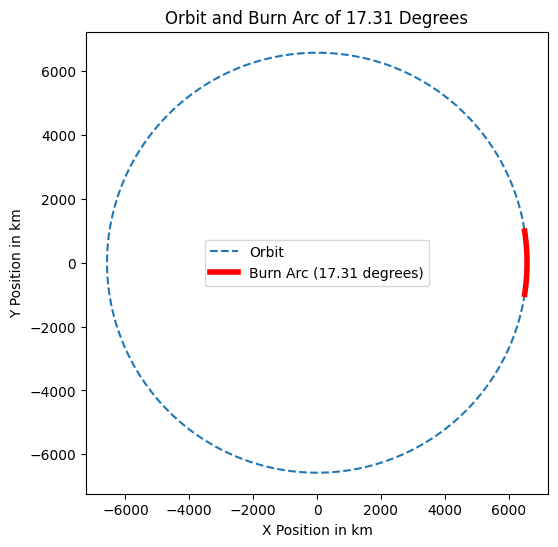

In [112]:
def rocket_performance(Name, Pc, dt, Tc, gamma, R, OF, Pa, g0, mass_dry, nozzle_expansion_ratio, density, h1, h2):
    # Derived values
    dt2 = math.sqrt(nozzle_expansion_ratio * dt)  # Nozzle exit diameter
    At = math.pi * (dt / 2) ** 2  # Throat area in square meters
    Ae = nozzle_expansion_ratio * At  # Nozzle exit area in square meters

    print(f"Using {Name}\n")

    # Print basic parameters
    print(f"Chamber pressure = {Pc*1e-6:.2f} MPa")
    print(f"Chamber temperature = {Tc} K")
    print(f"Throat diameter = {dt*1000} mm")
    print(f"Nozzle expansion ratio = {nozzle_expansion_ratio}")
    print(f"Nozzle exit diameter = {dt2:.4f} m")
    print(f"Nozzle exit area = {Ae:.4f} m^2")

    # Step 2: Calculate Effective Exhaust Velocity (ve) and Specific Impulse (ISP)
    def exit_mach_number_func(M, Ae, At, gamma):
        return (Ae/At - (1 / M) * ((2 / (gamma + 1)) * (1 + (gamma - 1) / 2 * M**2))**((gamma + 1) / (2 * (gamma - 1))))

    Me = float(scip.optimize.fsolve(exit_mach_number_func, 5, args=(Ae, At, gamma))[0])
    Te = Tc * (1 + (gamma - 1) / 2 * Me**2) ** -1
    Pe = Pc * (1 + (gamma - 1) / 2 * Me**2) ** (-gamma / (gamma - 1))
    ve = Me * math.sqrt(gamma * R * Te)
    ISP = ve / g0
    density_ISP = ISP * density
    print(f"\nExhaust mach number = {Me:.4f}")
    print(f"Exhaust velocity = {ve:.4f} m/s")
    print(f"Exhaust temperature = {Te:.4f} K")
    print(f"Exhaust pressure = {Pe:.4f} Pa")
    print(f"Specific Impulse (Isp) = {ISP:.4f} s")
    print(f"Density Impulse = {density_ISP:.4f} kg-s/m^3")

    # Step 3: Calculate the mass flow rate (dot_m)
    mass_flow_rate = (Pc * At / math.sqrt(Tc)) * math.sqrt(gamma / R) * ((2 / (gamma + 1)) ** ((gamma + 1) / (2 * (gamma - 1))))
    oxidizer_mass_flow_rate = mass_flow_rate * OF / (1 + OF)
    fuel_mass_flow_rate = mass_flow_rate - oxidizer_mass_flow_rate

    print(f"\nPropellant Mass Flow Rate = {mass_flow_rate:.4f} Kg/s")
    print(f"Fuel Mass Flow Rate = {fuel_mass_flow_rate:.4f} Kg/s")
    print(f"Oxidizer Mass Flow Rate = {oxidizer_mass_flow_rate:.4f} Kg/s")
    print(f"Oxidizer Volumetric Flow Rate = {oxidizer_mass_flow_rate/1600*1000:.4f} L/s")

    # Step 4: Calculate Thrust (Ft)
    thrust = mass_flow_rate * ve + (Pe - Pa) * Ae

    print(f"\nThrust = {thrust:.4f} N")

    # Step 5: Delta V Calculation
    R_E = 6378e3  # Earth's radius in meters
    mu = 3.985894e14  # Standard gravitational parameter for Earth in m^3/s^2

    # Initial and final orbital radii
    r1 = R_E + h1
    r2 = R_E + h2

    # Semi-major axis of the transfer orbit
    a_t = (r1 + r2) / 2

    # Orbital velocities
    v1 = math.sqrt(mu / r1)  # Initial orbit velocity
    vp = math.sqrt((2 * mu / r1) - (mu / a_t))  # Velocity at perigee of transfer orbit
    va = math.sqrt((2 * mu / r2) - (mu / a_t))  # Velocity at apogee of transfer orbit
    v2 = math.sqrt(mu / r2)  # Final orbit velocity

    # Delta V for each burn
    delta_v1 = vp - v1
    delta_v2 = v2 - va

    # Total Delta V
    delta_v_total = delta_v1 + delta_v2

    # Using Tsiolkovsky's rocket equation to find propellant mass
    mass_propellant = mass_dry * (math.exp(delta_v_total / ve) - 1)
    burn_time = mass_propellant / mass_flow_rate
    
    # Calculate final mass after first burn
    mass_initial = mass_propellant + mass_dry
    mass_f1 = mass_initial * math.exp(-delta_v1 / ve)
    
    # Calculate propellant mass required for first burn
    mass_propellant_parking= mass_initial - mass_f1
    
    # Calculate final mass after second burn
    mass_f2 = mass_f1 * math.exp(-delta_v2 / ve)

    # Calculate propellant mass required for second burn
    mass_propellant_injection = mass_f1 - mass_f2
    parking_burn_time = mass_propellant_parking / mass_flow_rate
    injection_burn_time = mass_propellant_injection / mass_flow_rate


    # Calculate the orbital period at LEO (T)
    LEO_period = 2 * math.pi * math.sqrt(r1**3 / mu)
    
    # Calculate time to traverse 10 degrees of the orbit
    arc_degrees = parking_burn_time*360/LEO_period

    print(f"\nDelta V total = {delta_v_total:.4f} m/s")
    print(f"Total propellant mass used = {mass_propellant:.4f} kg")
    print(f"    Propellant mass used at parking = {mass_propellant_parking:.4f} kg")
    print(f"    Propellant mass used at injection = {mass_propellant_injection:.4f} kg")
    print(f"    Dry mass = {mass_dry:.4f} kg")
    print(f"Total LEO wet mass = {mass_initial:.4f} kg")
    print(f"Total burn time = {burn_time:.2f} s")
    print(f"    Parking burn time = {parking_burn_time:.2f} s")
    print(f"    Injection burn time = {injection_burn_time:.2f} s")
    print(f"Orbital arc degrees over parking burn = {arc_degrees:.2f} deg")
    
    def plot_orbit_and_burn_arc(orbit_radius, arc_degrees):
        """
        Visualize the orbit and highlight the arc corresponding to a burn.
    
        Parameters:
        - orbit_radius: Radius of the orbit (in arbitrary units, e.g., km or AU)
        - arc_degrees: Arc length in degrees over which the burn occurs
        """
        # Full circle (orbit) points
        theta_full = np.linspace(0, 2 * np.pi, 1000)
        x_full = orbit_radius * np.cos(theta_full)
        y_full = orbit_radius * np.sin(theta_full)
    
        # Arc for the burn
        arc_radians = np.deg2rad(arc_degrees / 2)
        theta_arc = np.linspace(-arc_radians, arc_radians, 100)
        x_arc = orbit_radius * np.cos(theta_arc)
        y_arc = orbit_radius * np.sin(theta_arc)
    
        # Plotting the full orbit
        plt.figure(figsize=(6, 6))
        plt.plot(x_full, y_full, label='Orbit', linestyle='--')
    
        # Highlighting the arc
        plt.plot(x_arc, y_arc, color='red', label=f'Burn Arc ({arc_degrees:.2f} degrees)', linestyle='-', linewidth=4)
    
        # Plot aesthetics
        plt.title(f"Orbit and Burn Arc of {arc_degrees:.2f} Degrees")
        plt.xlabel('X Position in km')
        plt.ylabel('Y Position in km')
        plt.axhline(0, color='black', linewidth=0)
        plt.axvline(0, color='black', linewidth=0)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.legend()
        plt.show()

    plot_orbit_and_burn_arc(r1/1000, arc_degrees)
    return

# Example usage of the function with the given constants
rocket_performance(
    Name = 'HAN-Based Propellant', Pc=30e5, dt=0.0254, Tc=2500, gamma=1.2, R=300, OF=6, Pa=0, g0=9.807,
    mass_dry=100, nozzle_expansion_ratio=125, density=1600, h1=200e3, h2=35786e3
)
